<a href="https://colab.research.google.com/github/daiki-skm/oreilly-web-optimization/blob/main/chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

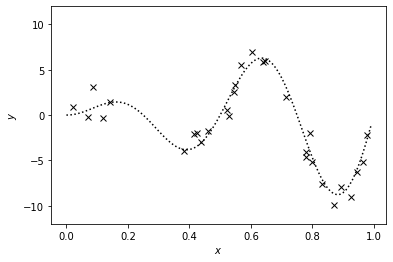

In [2]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(0)
X_star = np.arange(0,1,0.01)
n_points = 30
f = lambda x: 10 * x * np.sin(4 * np.pi * x)
X = np.sort(np.random.random(size=n_points))
r = f(X) + np.random.normal(0,1,size=n_points)
plt.ylim(-12,12)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X_star,f(X_star),color='black',linestyle='dotted')
plt.plot(X,r,'x',color='black')
plt.show()

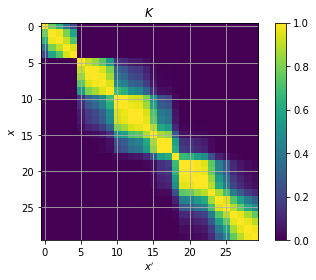

In [5]:
def gaussian_kernel(x1,x2,gamma=100):
  return np.exp(-gamma*(x1-x2)**2)

K = np.zeros((len(X),len(X)))
for i,xi in enumerate(X):
  for j,xj in enumerate(X):
    K[i,j] = gaussian_kernel(xi,xj)

plt.xlabel(r'$x^{\prime}$')
plt.ylabel(r'$x$')
plt.title(r'$K$')
plt.imshow(K)
plt.colorbar()
plt.grid(None)
plt.show()

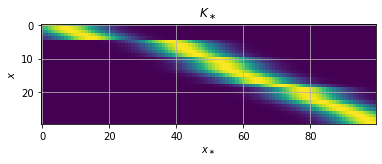

In [6]:
K_star = np.zeros((len(X),len(X_star)))
for i,xi in enumerate(X):
  for j,xj_star in enumerate(X_star):
    K_star[i,j] = gaussian_kernel(xi,xj_star)

plt.xlabel(r'$x_\ast$')
plt.ylabel(r'$x$')
plt.title(r'$K_\ast$')
plt.imshow(K_star)
plt.grid(None)
plt.show()

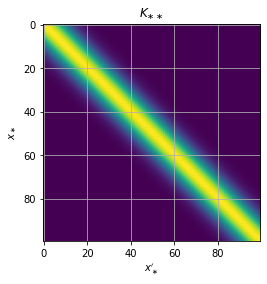

In [7]:
K_starstar = np.zeros((len(X_star),len(X_star)))
for i,xi_star in enumerate(X_star):
  for j,xj_star in enumerate(X_star):
    K_starstar[i,j] = gaussian_kernel(xi_star,xj_star)

plt.xlabel(r'$x_\ast^{\prime}$')
plt.ylabel(r'$x_\ast$')
plt.title(r'$K_{\ast\ast}$')
plt.imshow(K_starstar)
plt.grid(None)
plt.show()

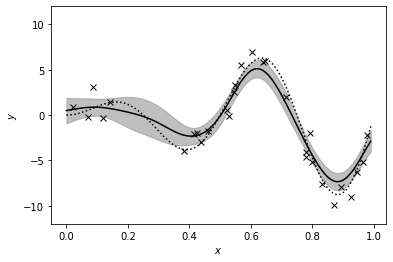

In [8]:
s = 1
A = np.linalg.inv(K+s*np.eye(K.shape[0]))
mu = np.dot(np.dot(K_star.T,A),r)
sigma = K_starstar - np.dot(np.dot(K_star.T,A),K_star)
plt.ylim(-12,12)
plt.plot(X_star,f(X_star),color='black',linestyle='dotted')
plt.fill_between(X_star,mu-2*np.sqrt(np.diag(sigma)),mu+2*np.sqrt(np.diag(sigma)),alpha=0.5,color='gray')
plt.plot(X_star,mu,color='black')
plt.plot(X,r,'x',color='black')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

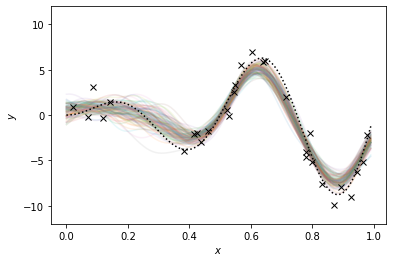

In [9]:
plt.ylim(-12,12)
for _ in range(100):
  plt.plot(X_star,np.random.multivariate_normal(mu,sigma),alpha=0.1)
plt.plot(X_star,f(X_star),color='black',linestyle='dotted')
plt.plot(X,r,'x',color='black')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

In [12]:
gamma = 100
X = np.expand_dims(X,0)
X_star = np.expand_dims(X_star,0)
Q = np.dot(X.T,X)
Q_star = np.dot(X.T,X_star)
Q_starstar = np.dot(X_star.T,X_star)
K = np.exp(-gamma*(np.tile(np.diag(Q),(X.shape[1],1)).T - 2*Q + np.tile(np.diag(Q),(X.shape[1],1))))
K_star = np.exp(-gamma*(np.tile(np.diag(Q),(X_star.shape[1],1)).T - 2*Q_star + np.tile(np.diag(Q_starstar),(X.shape[1],1))))
K_starstar = np.exp(-gamma*(np.tile(np.diag(Q_starstar),(X_star.shape[1],1)).T - 2*Q_starstar + np.tile(np.diag(Q_starstar),(X.shape[1],1))))
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.title(r'$K$')
plt.imshow(K)
plt.grid(None)
plt.subplot(1,3,2)
plt.title(r'$K_\ast$')
plt.imshow(K_star)
plt.grid(None)
plt.subplot(1,3,3)
plt.title(r'$K_{\ast\ast}$')
plt.imshow(K_starstar)
plt.grid(None)
plt.show()

ValueError: ignored

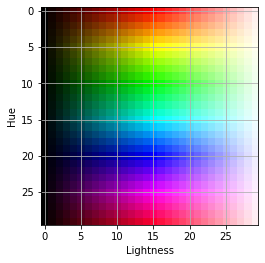

In [14]:
import colorsys

N = 30
X_im = np.zeros((N,N,2))
rs = []
xs = []
for i in range(N):
  for j in range(N):
    X_im[i,j,0] = i/N
    X_im[i,j,1] = j/N
hl_to_rgb = lambda x: colorsys.hls_to_rgb(x[0],x[1],1)
X_rgb = np.apply_along_axis(hl_to_rgb,-1,X_im)
plt.imshow(X_rgb)
plt.grid(None)
plt.xlabel('Lightness')
plt.ylabel('Hue')
plt.show()

In [15]:
X_star = X_im.reshape((N*N,2)).T

class GPUCBAgent(object):
  def __init__(self):
    self.xs = []
    self.rs = []
    self.gamma = 10
    self.s = 0.5
    self.alpha = 2
    self.Q_starstar = X_star.T.dot(X_star)
    self.K_starstar = np.exp(-self.gamma*(np.tile(np.diag(self.Q_starstar),(X_star.shape[1],1)).T-2*self.Q_starstar+np.tile(np.diag(self.Q_starstar),(X_star.shape[1],1))))
    self.mu = np.zeros(self.K_starstar.shape[0])
    self.sigma = self.K_starstar
  
  def get_arm(self):
    ucb = self.mu + self.alpha * np.diag(self.sigma)
    return X_star[:,np.argmax(ucb)],ucb
  
  def sample(self,x,r):
    self.xs.append(x)
    self.rs.append(r)
    X = np.array(self.xs).T
    Q = X.T.dot(X)
    Q_star = X.T.dot(X_star)
    K = np.exp(-self.gamma*(np.tile(np.diag(self.Q),(X_star.shape[1],1)).T-2*self.Q+np.tile(np.diag(self.Q),(X_star.shape[1],1))))
    K_star = np.exp(-self.gamma*(np.tile(np.diag(self.Q),(X_star.shape[1],1)).T-2*self.Q_star+np.tile(np.diag(self.Q_starstar),(X_star.shape[1],1))))
    A = np.linalg.inv(self.s+np.identity(K.shape[0])+K)
    self.mu = K_star.T.dot(A).dot(self.rs)
    self.sigma = self.K_starstar-K_star.T.dot(A).dot(K_star)